In [1]:
#Regresion Stock Prices  with Keras LTSM Network

from pandas import read_csv
from pandas import datetime
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import library as mio



Using TensorFlow backend.
j:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
j:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# reduced list only the most correlated
indices_list_Complete = ["SPY","^IXIC", "^DJI", "^GDAXI", "^FTSE","^FCHI", "^N225","^HSI", "^AXJO","ORB", "EUR","AUD","GBP","JPY", "SILVER", "GOLD", "WT1010"] # reduced list only the most correlated
indice_target=["^GSPC"]

In [3]:
start_date = "2003-01-01" # Start day of Series
end_date = "2017-01-01"	  # Final day of series
dates = pd.date_range(start_date, end_date)  # date range as index

In [4]:
df_index = mio.get_data(indices_list_Complete, dates)
df_target= mio.get_data(indice_target, dates)

In [5]:
df_index.fillna(method='bfill', inplace=True)
df_target.fillna(method='bfill', inplace=True)

In [6]:
df_index.tail()

,SPY,^IXIC,^DJI,^GDAXI,^FTSE,^FCHI,^N225,^HSI,^AXJO,ORB,EUR,AUD,GBP,JPY,SILVER,GOLD,WT1010
2016-12-23,224.732324,5462.689941,19933.810547,11449.929688,7068.200195,4839.680176,19403.060547,21574.759766,5627.899902,51.74,0.957179,1.394655,0.814821,117.185667,15.74,1131.00,0.25
2016-12-27,225.289896,5487.439941,19945.039062,11472.240234,7106.100098,4848.279785,19403.060547,21754.740234,5685.000000,52.25,0.956361,1.391288,0.815262,117.457200,15.85,1139.75,0.21
2016-12-28,223.427985,5438.560059,19833.679688,11474.990234,7106.100098,4848.009766,19401.720703,21754.740234,5685.000000,53.39,0.963017,1.393879,0.817868,117.543337,15.85,1139.75,0.19
2016-12-29,223.378214,5432.089844,19819.779297,11451.049805,7120.299805,4838.470215,19145.140625,21790.910156,5699.100098,53.46,0.954902,1.387659,0.817942,116.505533,16.06,1146.80,0.17
2016-12-30,222.561759,5383.120117,19762.599609,11481.059570,7142.799805,4862.310059,19114.369141,22000.560547,5665.799805,53.30,0.948191,1.385629,0.810056,116.637500,16.24,1159.10,0.19


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

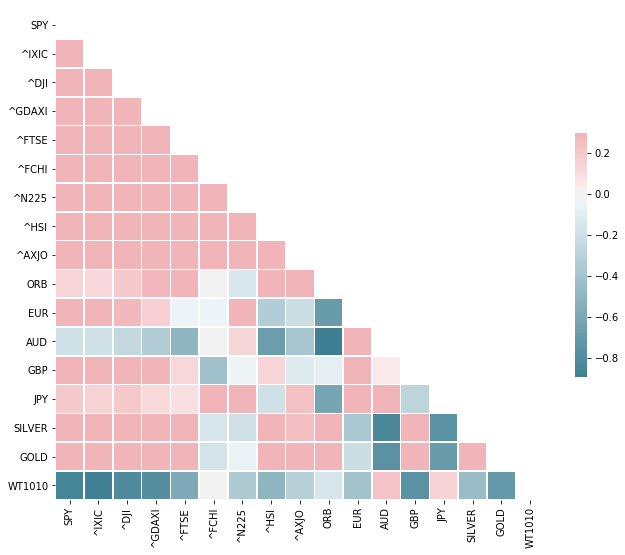

In [8]:
corr = df_index.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [9]:
df_target.tail()

,^GSPC
2016-12-23,2263.790039
2016-12-27,2268.879883
2016-12-28,2249.919922
2016-12-29,2249.260010
2016-12-30,2238.830078


In [10]:
def shift_minus(df, list_s, n):
    for symbol in list_s:
        M = pd.Series(df[symbol].shift(-1), name = str(symbol)+"-" + str(n))
        df=df.join(M)
    return df

In [11]:
df_target_2=shift_minus(df_index, indices_list_Complete,1)

In [12]:
df_target_2.drop(df_target_2.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], axis=1, inplace=True)

In [13]:
df_final=df_target.join(df_target_2)
M = pd.Series(df_target["^GSPC"].shift(-1), name = "^GSPC-" + str(1))
df_final = df_final.join(M)

In [14]:
df_final = df_final[:-1]


In [15]:
indexs=df_final.index

In [16]:
values = df_final.values
train_size = int(len(values) * 0.66)
train, test = values[0:train_size], values[train_size:len(values)]
print('Observations: %d' % (len(values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 3524
Training Observations: 2325
Testing Observations: 1199


In [17]:
df_test=df_final[train_size:len(values)]

In [18]:
indexs=df_test.index

In [19]:
indexs

DatetimeIndex(['2012-03-27', '2012-03-28', '2012-03-29', '2012-03-30',
               '2012-04-02', '2012-04-03', '2012-04-04', '2012-04-05',
               '2012-04-09', '2012-04-10',
               ...
               '2016-12-15', '2016-12-16', '2016-12-19', '2016-12-20',
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2016-12-29'],
              dtype='datetime64[ns]', length=1199, freq=None)

In [20]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]



In [21]:
test_y

array([1405.540039, 1403.280029, 1408.469971, ..., 2249.919922,
       2249.26001 , 2238.830078])

In [22]:
# normalize features
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
train_XS = min_max_scaler.fit_transform(train_X)
#train_yS = min_max_scaler.fit_transform(train_y)
test_XS = min_max_scaler.fit_transform(test_X)
#test_yS = min_max_scaler.fit_transform(test_y)

In [23]:
max_value = train_y.max()
min_value = train_y.min()
train_yS= (train_y - min_value) / (max_value - min_value)

In [24]:
max_value2 = test_y.max()
min_value2 = test_y.min()
test_yS= (test_y - min_value2) / (max_value2 - min_value2)

In [25]:
test_yS

array([0.12831093, 0.12603655, 0.1312595 , ..., 0.9780613 , 0.97739719,
       0.96690092])

In [26]:
train_XS = train_XS.reshape((train_XS.shape[0], 1, train_XS.shape[1]))
test_XS = test_XS.reshape((test_XS.shape[0], 1, test_XS.shape[1]))
print(train_XS.shape, train_yS.shape, test_XS.shape, test_yS.shape)

(2325, 1, 18) (2325,) (1199, 1, 18) (1199,)


In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

In [28]:
# design network
model = Sequential()
#model.add(GRU(32, input_shape=(train_XS.shape[1], train_XS.shape[2])))# GRU Cell
model.add(LSTM(32,activation='softmax', input_shape=(train_XS.shape[1], train_XS.shape[2])))# LSTM Cell
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [29]:
history = model.fit(train_XS, train_yS, epochs=250, batch_size=16, validation_data=(test_XS, test_yS), verbose=2, shuffle=False)

Train on 2325 samples, validate on 1199 samples
Epoch 1/250
 - 1s - loss: 0.2730 - mean_squared_error: 0.2730 - mean_absolute_error: 0.4857 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - val_mean_absolute_error: 0.3941
Epoch 2/250
 - 0s - loss: 0.1220 - mean_squared_error: 0.1220 - mean_absolute_error: 0.3093 - val_loss: 0.1077 - val_mean_squared_error: 0.1077 - val_mean_absolute_error: 0.2880
Epoch 3/250
 - 0s - loss: 0.0548 - mean_squared_error: 0.0548 - mean_absolute_error: 0.2010 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.2273
Epoch 4/250
 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1425 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1961
Epoch 5/250
 - 0s - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1149 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1801
Epoch 6/250
 - 0s - loss: 0.0155 - mean_squared_error: 0.0155 

Epoch 46/250
 - 0s - loss: 1.2893e-04 - mean_squared_error: 1.2893e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0429
Epoch 47/250
 - 0s - loss: 1.2241e-04 - mean_squared_error: 1.2241e-04 - mean_absolute_error: 0.0076 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0422
Epoch 48/250
 - 0s - loss: 1.1629e-04 - mean_squared_error: 1.1629e-04 - mean_absolute_error: 0.0074 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0413
Epoch 49/250
 - 0s - loss: 1.1040e-04 - mean_squared_error: 1.1040e-04 - mean_absolute_error: 0.0072 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0405
Epoch 50/250
 - 0s - loss: 1.0507e-04 - mean_squared_error: 1.0507e-04 - mean_absolute_error: 0.0071 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0397
Epoch 51/250
 - 0s - loss: 1.0014e-04 - mean_squared_error: 1.001

Epoch 89/250
 - 0s - loss: 4.9410e-05 - mean_squared_error: 4.9410e-05 - mean_absolute_error: 0.0053 - val_loss: 7.6025e-04 - val_mean_squared_error: 7.6025e-04 - val_mean_absolute_error: 0.0226
Epoch 90/250
 - 0s - loss: 4.9593e-05 - mean_squared_error: 4.9593e-05 - mean_absolute_error: 0.0053 - val_loss: 7.6328e-04 - val_mean_squared_error: 7.6328e-04 - val_mean_absolute_error: 0.0227
Epoch 91/250
 - 0s - loss: 4.9997e-05 - mean_squared_error: 4.9997e-05 - mean_absolute_error: 0.0053 - val_loss: 7.6988e-04 - val_mean_squared_error: 7.6988e-04 - val_mean_absolute_error: 0.0228
Epoch 92/250
 - 0s - loss: 5.0357e-05 - mean_squared_error: 5.0357e-05 - mean_absolute_error: 0.0053 - val_loss: 7.7592e-04 - val_mean_squared_error: 7.7592e-04 - val_mean_absolute_error: 0.0230
Epoch 93/250
 - 0s - loss: 5.1019e-05 - mean_squared_error: 5.1019e-05 - mean_absolute_error: 0.0054 - val_loss: 7.8479e-04 - val_mean_squared_error: 7.8479e-04 - val_mean_absolute_error: 0.0232
Epoch 94/250
 - 0s - loss

Epoch 131/250
 - 0s - loss: 3.4407e-05 - mean_squared_error: 3.4407e-05 - mean_absolute_error: 0.0045 - val_loss: 4.1351e-04 - val_mean_squared_error: 4.1351e-04 - val_mean_absolute_error: 0.0169
Epoch 132/250
 - 0s - loss: 3.4401e-05 - mean_squared_error: 3.4401e-05 - mean_absolute_error: 0.0045 - val_loss: 4.0534e-04 - val_mean_squared_error: 4.0534e-04 - val_mean_absolute_error: 0.0166
Epoch 133/250
 - 0s - loss: 3.4303e-05 - mean_squared_error: 3.4303e-05 - mean_absolute_error: 0.0045 - val_loss: 3.9955e-04 - val_mean_squared_error: 3.9955e-04 - val_mean_absolute_error: 0.0164
Epoch 134/250
 - 0s - loss: 3.4412e-05 - mean_squared_error: 3.4412e-05 - mean_absolute_error: 0.0045 - val_loss: 3.9741e-04 - val_mean_squared_error: 3.9741e-04 - val_mean_absolute_error: 0.0163
Epoch 135/250
 - 0s - loss: 3.4582e-05 - mean_squared_error: 3.4582e-05 - mean_absolute_error: 0.0045 - val_loss: 3.9951e-04 - val_mean_squared_error: 3.9951e-04 - val_mean_absolute_error: 0.0163
Epoch 136/250
 - 0s 

Epoch 173/250
 - 0s - loss: 3.5918e-05 - mean_squared_error: 3.5918e-05 - mean_absolute_error: 0.0046 - val_loss: 2.8357e-04 - val_mean_squared_error: 2.8357e-04 - val_mean_absolute_error: 0.0141
Epoch 174/250
 - 1s - loss: 3.5844e-05 - mean_squared_error: 3.5844e-05 - mean_absolute_error: 0.0046 - val_loss: 2.6525e-04 - val_mean_squared_error: 2.6525e-04 - val_mean_absolute_error: 0.0135
Epoch 175/250
 - 0s - loss: 3.5485e-05 - mean_squared_error: 3.5485e-05 - mean_absolute_error: 0.0046 - val_loss: 2.5103e-04 - val_mean_squared_error: 2.5103e-04 - val_mean_absolute_error: 0.0130
Epoch 176/250
 - 0s - loss: 3.5386e-05 - mean_squared_error: 3.5386e-05 - mean_absolute_error: 0.0046 - val_loss: 2.4348e-04 - val_mean_squared_error: 2.4348e-04 - val_mean_absolute_error: 0.0127
Epoch 177/250
 - 0s - loss: 3.5935e-05 - mean_squared_error: 3.5935e-05 - mean_absolute_error: 0.0047 - val_loss: 2.4101e-04 - val_mean_squared_error: 2.4101e-04 - val_mean_absolute_error: 0.0125
Epoch 178/250
 - 0s 

Epoch 215/250
 - 0s - loss: 5.6081e-05 - mean_squared_error: 5.6081e-05 - mean_absolute_error: 0.0061 - val_loss: 4.3402e-04 - val_mean_squared_error: 4.3402e-04 - val_mean_absolute_error: 0.0175
Epoch 216/250
 - 0s - loss: 5.5428e-05 - mean_squared_error: 5.5428e-05 - mean_absolute_error: 0.0061 - val_loss: 4.4450e-04 - val_mean_squared_error: 4.4450e-04 - val_mean_absolute_error: 0.0178
Epoch 217/250
 - 0s - loss: 5.4219e-05 - mean_squared_error: 5.4219e-05 - mean_absolute_error: 0.0061 - val_loss: 4.5773e-04 - val_mean_squared_error: 4.5773e-04 - val_mean_absolute_error: 0.0181
Epoch 218/250
 - 0s - loss: 5.2529e-05 - mean_squared_error: 5.2529e-05 - mean_absolute_error: 0.0060 - val_loss: 4.7018e-04 - val_mean_squared_error: 4.7018e-04 - val_mean_absolute_error: 0.0184
Epoch 219/250
 - 0s - loss: 5.0448e-05 - mean_squared_error: 5.0448e-05 - mean_absolute_error: 0.0058 - val_loss: 4.7349e-04 - val_mean_squared_error: 4.7349e-04 - val_mean_absolute_error: 0.0184
Epoch 220/250
 - 0s 

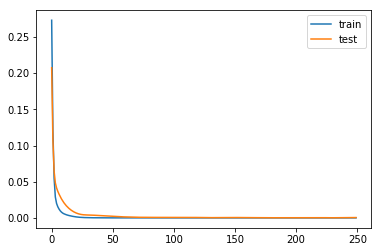

In [30]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

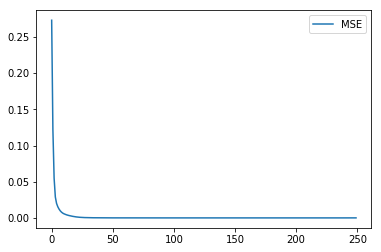

In [31]:
# plot metrics
pyplot.plot(history.history['mean_squared_error'], label='MSE')
#pyplot.plot(history.history['mean_absolute_error'],label='MAE')
pyplot.legend()
pyplot.show()

In [32]:
# make a prediction
yhat = model.predict(test_XS)
test_XS = test_XS.reshape((test_XS.shape[0], test_XS.shape[2]))

In [33]:
# invert scaling for forecast
max_value2 = test_y.max()
min_value2 = test_y.min()
inv_yhat= (yhat * (max_value2 - min_value2))+min_value2


In [34]:
inv_yhat

array([[1418.3876],
       [1419.0867],
       [1425.103 ],
       ...,
       [2214.0637],
       [2213.689 ],
       [2210.5237]], dtype=float32)

In [35]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.051


In [36]:
lowerx=inv_yhat-(2*rmse)
upperx=inv_yhat+(2*rmse)

In [37]:
inv_yhat

array([[1418.3876],
       [1419.0867],
       [1425.103 ],
       ...,
       [2214.0637],
       [2213.689 ],
       [2210.5237]], dtype=float32)

In [38]:
#upper=np.array([sp500[['Upper band']]["2017-12-01":].values]).reshape(len(sp500a),)
upper=upperx.reshape(len(inv_yhat),)
lower=lowerx.reshape(len(inv_yhat),)

In [39]:
upper.shape

(1199,)

Test RMSE: 23.051
Test R2: 0.993


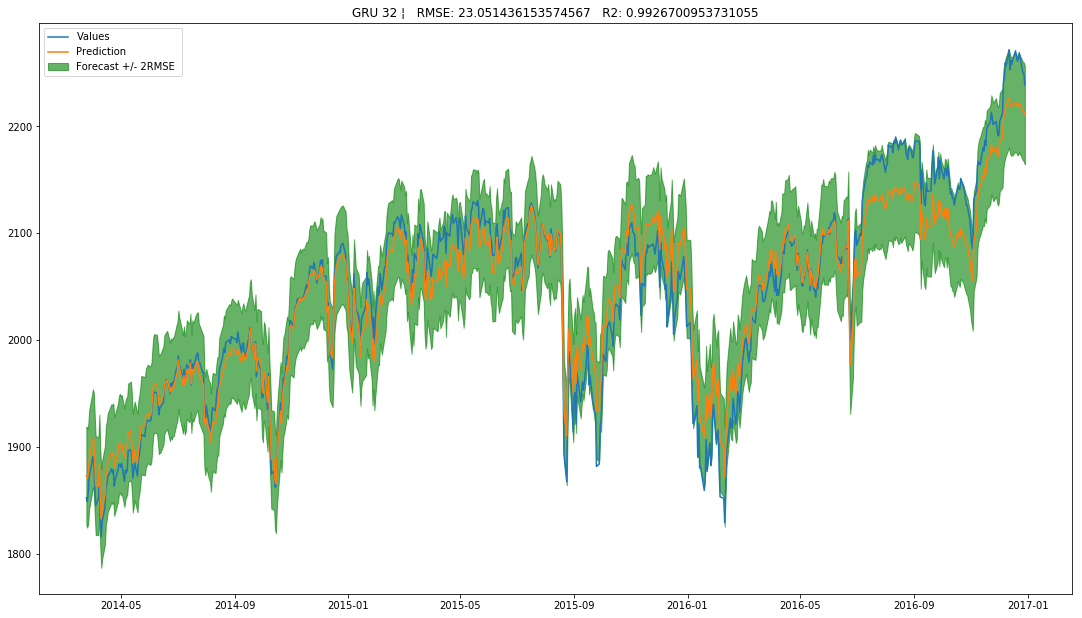

In [40]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, inv_yhat))
r2=r2_score(test_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.set_size_inches(18.5, 10.5, forward=True)
pyplot.plot(indexs[500:],test_y[500:], label='Values')
pyplot.plot(indexs[500:],inv_yhat[500:], label='Prediction')
pyplot.fill_between(indexs[500:],upper[500:],lower[500:], color='g', alpha=0.6, label='Forecast +/- 2RMSE ')
pyplot.legend()
pyplot.title("GRU 32 ¦   RMSE: " +str(rmse)+ "   R2: " + str(r2))
pyplot.show()